Visualising our Van Rossum loss to check if it's working as expected

In [1]:
from training_utils.losses import VanRossumLoss
import matplotlib.pyplot as plt
import torch

In [2]:
# make random spiketrain
t = 1.0  # seconds
dt = 0.001  # seconds
r = 5  # Hz
spiketrain = (torch.rand(int(t / dt)) < r * dt).float()
spiketrain = spiketrain[None, :, None]
empty_spiketrain = torch.zeros_like(spiketrain)
spiketrain2 = (torch.rand(int(t / dt)) < r * dt).float()
spiketrain2 = spiketrain2[None, :, None]

In [3]:
vr_loss = VanRossumLoss(tau=0.02, dt=dt, window_size=100, debug=True)

In [4]:
loss, output_smooth, target_smooth = vr_loss(spiketrain, spiketrain2)

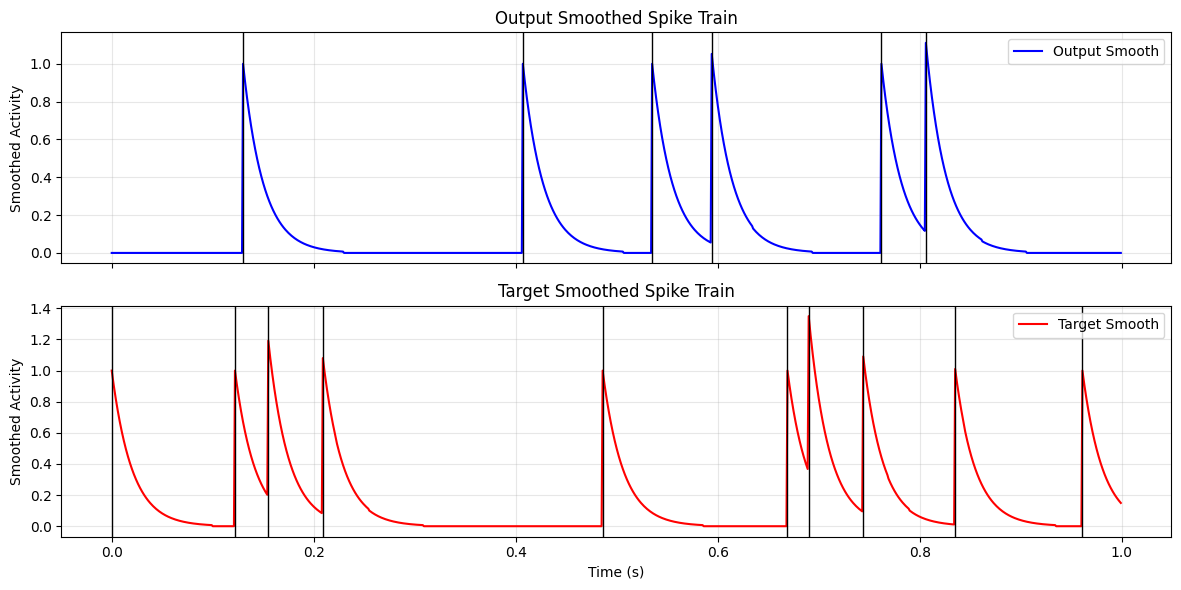

In [5]:
# Prepare data for plotting
time_axis = torch.arange(spiketrain.shape[1]) * dt
spike_indices = torch.where(spiketrain[0, :, 0])[0]
spike_indices2 = torch.where(spiketrain2[0, :, 0])[0]
output_smooth_plot = output_smooth[0, 0, :].detach()
target_smooth_plot = target_smooth[0, 0, :].detach()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot output smooth with spikes
ax1.plot(
    time_axis, output_smooth_plot, label="Output Smooth", color="blue", linewidth=1.5
)
for spike_idx in spike_indices:
    ax1.axvline(x=spike_idx * dt, color="black", alpha=1.0, linewidth=1.0)
ax1.set_ylabel("Smoothed Activity")
ax1.set_title("Output Smoothed Spike Train")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot target smooth with spikes
ax2.plot(
    time_axis, target_smooth_plot, label="Target Smooth", color="red", linewidth=1.5
)
for spike_idx in spike_indices2:
    ax2.axvline(x=spike_idx * dt, color="black", alpha=1.0, linewidth=1.0)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Smoothed Activity")
ax2.set_title("Target Smoothed Spike Train")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Firing Rate Bias in Van Rossum Loss

The Van Rossum loss has an inherent bias towards lower firing rates. When comparing an output spike train to a target, **deleting a spike** often produces a lower loss than **displacing it** by a small amount.

This is because:
- A deleted spike only contributes error where the target spike's filtered trace exists
- A displaced spike contributes error in TWO places: where it shouldn't be AND where it should be

We demonstrate this below with identical spike trains where we either delete or displace a single spike.

In [6]:
# Create a target spike train with ~5 spikes at fixed positions
t = 1.0  # seconds
dt = 0.001  # seconds
n_steps = int(t / dt)

# Target spike train with 5 spikes at specific times
target = torch.zeros(1, n_steps, 1)
spike_times_ms = [100, 300, 500, 700, 900]  # evenly spaced
for t_ms in spike_times_ms:
    target[0, t_ms, 0] = 1.0

# Case 1: Missing spike (delete the middle spike at 500ms)
output_missing = target.clone()
output_missing[0, 500, 0] = 0.0

# Case 2: Displaced spike (move the middle spike by 50ms)
displacement = 50  # ms
output_displaced = target.clone()
output_displaced[0, 500, 0] = 0.0
output_displaced[0, 500 + displacement, 0] = 1.0

# Compute losses
vr_loss_debug = VanRossumLoss(tau=0.02, dt=dt, window_size=100, debug=True)

loss_missing, smooth_missing, smooth_target = vr_loss_debug(output_missing, target)
loss_displaced, smooth_displaced, _ = vr_loss_debug(output_displaced, target)

print(f"Loss with MISSING spike:    {loss_missing.item():.6f}")
print(f"Loss with DISPLACED spike:  {loss_displaced.item():.6f}")
print(f"Ratio (displaced/missing):  {loss_displaced.item() / loss_missing.item():.2f}x")

Loss with MISSING spike:    0.010508
Loss with DISPLACED spike:  0.019302
Ratio (displaced/missing):  1.84x


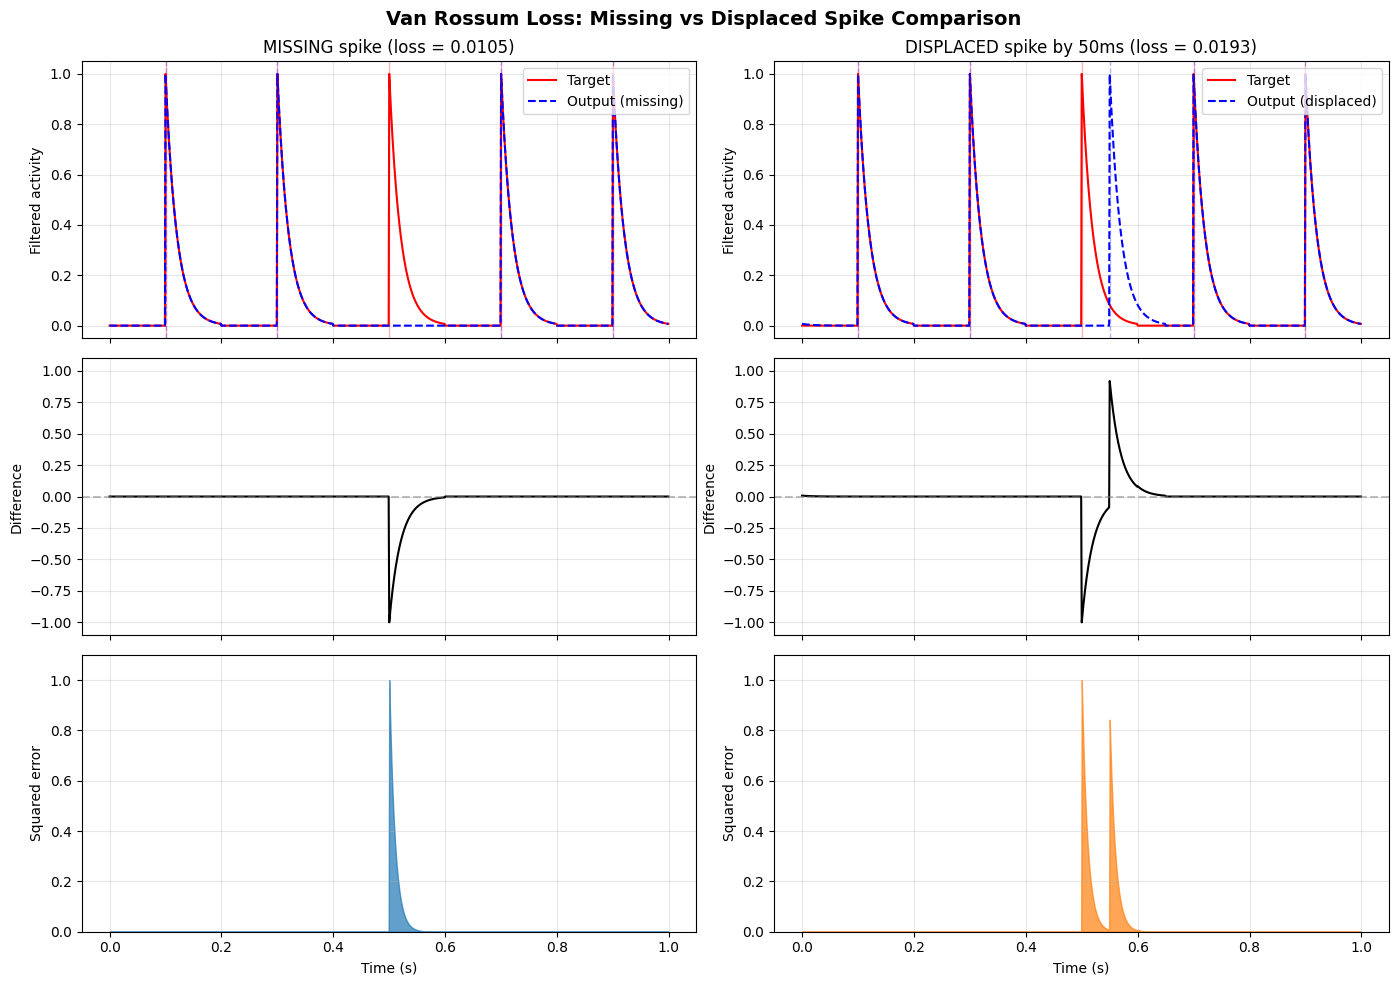


The displaced spike has 1.8x higher loss than the missing spike.
This demonstrates the bias: the loss function 'prefers' deleting spikes over displacing them.


In [7]:
# Plot comparison: Missing vs Displaced spike
time_axis = torch.arange(n_steps) * dt

fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True)

# Extract smoothed traces
smooth_target_plot = smooth_target[0, 0, :].detach()
smooth_missing_plot = smooth_missing[0, 0, :].detach()
smooth_displaced_plot = smooth_displaced[0, 0, :].detach()

# Compute differences and squared errors
diff_missing = smooth_missing_plot - smooth_target_plot
diff_displaced = smooth_displaced_plot - smooth_target_plot
sq_error_missing = diff_missing**2
sq_error_displaced = diff_displaced**2

# Compute shared axis limits
diff_min = min(diff_missing.min().item(), diff_displaced.min().item())
diff_max = max(diff_missing.max().item(), diff_displaced.max().item())
diff_lim = max(abs(diff_min), abs(diff_max)) * 1.1
sq_error_max = max(sq_error_missing.max().item(), sq_error_displaced.max().item()) * 1.1

# Get spike indices for plotting
target_spike_idx = torch.where(target[0, :, 0])[0]
missing_spike_idx = torch.where(output_missing[0, :, 0])[0]
displaced_spike_idx = torch.where(output_displaced[0, :, 0])[0]

# Column 1: Missing spike case
# Row 1: Filtered spike trains
ax = axes[0, 0]
ax.plot(time_axis, smooth_target_plot, "r-", label="Target", linewidth=1.5)
ax.plot(time_axis, smooth_missing_plot, "b--", label="Output (missing)", linewidth=1.5)
for idx in target_spike_idx:
    ax.axvline(x=idx * dt, color="red", alpha=0.3, linewidth=1)
for idx in missing_spike_idx:
    ax.axvline(x=idx * dt, color="blue", alpha=0.3, linewidth=1, linestyle="--")
ax.set_ylabel("Filtered activity")
ax.set_title(f"MISSING spike (loss = {loss_missing.item():.4f})")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# Row 2: Difference
ax = axes[1, 0]
ax.plot(time_axis, diff_missing, "k-", linewidth=1.5)
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Difference")
ax.set_ylim(-diff_lim, diff_lim)
ax.grid(True, alpha=0.3)

# Row 3: Squared error
ax = axes[2, 0]
ax.fill_between(time_axis, 0, sq_error_missing, alpha=0.7, color="C0")
ax.set_ylabel("Squared error")
ax.set_xlabel("Time (s)")
ax.set_ylim(0, sq_error_max)
ax.grid(True, alpha=0.3)

# Column 2: Displaced spike case
# Row 1: Filtered spike trains
ax = axes[0, 1]
ax.plot(time_axis, smooth_target_plot, "r-", label="Target", linewidth=1.5)
ax.plot(
    time_axis, smooth_displaced_plot, "b--", label="Output (displaced)", linewidth=1.5
)
for idx in target_spike_idx:
    ax.axvline(x=idx * dt, color="red", alpha=0.3, linewidth=1)
for idx in displaced_spike_idx:
    ax.axvline(x=idx * dt, color="blue", alpha=0.3, linewidth=1, linestyle="--")
ax.set_ylabel("Filtered activity")
ax.set_title(
    f"DISPLACED spike by {displacement}ms (loss = {loss_displaced.item():.4f})"
)
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# Row 2: Difference
ax = axes[1, 1]
ax.plot(time_axis, diff_displaced, "k-", linewidth=1.5)
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Difference")
ax.set_ylim(-diff_lim, diff_lim)
ax.grid(True, alpha=0.3)

# Row 3: Squared error
ax = axes[2, 1]
ax.fill_between(time_axis, 0, sq_error_displaced, alpha=0.7, color="C1")
ax.set_ylabel("Squared error")
ax.set_xlabel("Time (s)")
ax.set_ylim(0, sq_error_max)
ax.grid(True, alpha=0.3)

plt.suptitle(
    "Van Rossum Loss: Missing vs Displaced Spike Comparison",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

print(
    f"\nThe displaced spike has {loss_displaced.item() / loss_missing.item():.1f}x higher loss than the missing spike."
)
print(
    "This demonstrates the bias: the loss function 'prefers' deleting spikes over displacing them."
)